In [1]:
import pandas as pd

In [2]:
# Read file into pandas DataFrame

p3d_diag= pd.read_csv("C:\\PASC_Pilot\\DATA\\Post3day_diag_phe.csv")
p3d_diag.head()

,CONDITION_OCCURRENCE_ID,VISIT_OCCURRENCE_ID,PERSON_ID,CONDITION_START_DATE,CONDITION_END_DATE,CONDITION_TYPE_SOURCE_NAME,CONDITION_TYPE_CONCEPT_ID,CONDITION_TYPE_CONCEPT_NAME,COVID_date,COVID_Pos,post_30days,CONDITION_SOURCE_VALUE,CONDITION_SOURCE_VALUE_DESCRIPTION
0,10785504,13752498,1164758,2021-07-01,2021-07-01,Billing Diagnosis,32019,EHR billing diagnosis,2020-12-01,Yes,2020-12-31,NaN,Encounter for gynecological examination (gener...
1,13650919,16085344,1164758,2021-09-13,2021-09-13,Billing Diagnosis,32019,EHR billing diagnosis,2020-12-01,Yes,2020-12-31,MB_288,Anxiety and anxiety disorders
2,13650919,16085344,1164758,2021-09-13,2021-09-13,Billing Diagnosis,32019,EHR billing diagnosis,2020-12-01,Yes,2020-12-31,MB_290,"Reaction to severe stress, and adjustment diso..."
3,6247038,10373564,1164758,2021-03-08,2021-03-08,Billing Diagnosis,32019,EHR billing diagnosis,2020-12-01,Yes,2020-12-31,MB_288,Anxiety and anxiety disorders
4,6247038,10373564,1164758,2021-03-08,2021-03-08,Billing Diagnosis,32019,EHR billing diagnosis,2020-12-01,Yes,2020-12-31,MB_290,"Reaction to severe stress, and adjustment diso..."


In [3]:
p3d_diag['PERSON_ID'].nunique()

10573

In [4]:
import re

# Filter out those who U09 to create the positive labels
pattern = 'SS_807.3'
pasc_diag = p3d_diag[p3d_diag['CONDITION_SOURCE_VALUE'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

In [5]:
pasc_diag['PERSON_ID'].nunique()

167

In [6]:
pasc_diag = pd.DataFrame({'PERSON_ID': pasc_diag['PERSON_ID'].unique()})

In [7]:
pasc_diag.shape

(167, 1)

In [8]:
pasc_diag.head(30)

,PERSON_ID
0,1991813
1,1223174
2,3035829
3,1636783
4,1990878
5,1523186
6,1520780
7,1400965
8,1641751
9,1814786


In [9]:
pasc_diag['PASC'] = '1'

In [10]:
p3d_diag['dummy'] = 1

In [11]:
grouped_counts = p3d_diag.groupby(['PERSON_ID', 'CONDITION_SOURCE_VALUE_DESCRIPTION']).size().reset_index(name='counts')

In [12]:
def process_chunk(chunk):
    # Group by PERSON_ID and CONDITION_SOURCE_VALUE_DESCRIPTION to get the counts
    grouped_counts = chunk.groupby(['PERSON_ID', 'CONDITION_SOURCE_VALUE_DESCRIPTION']).size().reset_index(name='counts')
    
    # Pivot the grouped data
    chunk_pivot = grouped_counts.pivot(index='PERSON_ID', 
                                       columns='CONDITION_SOURCE_VALUE_DESCRIPTION', 
                                       values='counts').fillna(0)
    
    return chunk_pivot

# Define chunk size
chunk_size = 1000  # You can adjust this based on your system's memory

# Create a list to hold the results of each chunk
results = []

# Split the data into chunks and process each chunk
for start in range(0, len(p3d_diag), chunk_size):
    chunk = p3d_diag.iloc[start:start+chunk_size]
    results.append(process_chunk(chunk))

# Combine the results
diag_features = pd.concat(results).groupby(level=0).sum()


In [13]:
diag_features.head()

CONDITION_SOURCE_VALUE_DESCRIPTION,Abnormal electrocardiogram [ECG] [EKG],Abnormal findings on diagnostic imaging of the digestive tract,Abnormal findings on examination of blood,Abnormal glucose,Abnormal mammogram,Abnormal weight gain,Acidosis,Acne,Acquired absence of other part of head and neck,Acute lymphoid leukemia,...,Congenital adrenogenital disorders associated with enzyme deficiency*,Congenital anomalies of adrenal gland,"Hand, foot, and mouth disease",Congenital malformations of integument,Ectodermal dysplasia,"Open bite of right little finger without damage to nail, initial encounter",Pallor,"Puncture wound without foreign body, right foot, subsequent encounter","Puncture wound without foreign body, unspecified foot, subsequent encounter","Exposure to excessive natural cold, initial encounter"
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1161110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161136,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161151,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161165,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# read the new demographic file into pandas DataFrame
dem_df= pd.read_csv("C:\\PASC_Pilot\\DATA\\new_dem.csv")
dem_df.head()

,PERSON_ID,AGE,age_group,GENDER_CONCEPT_VALUE,RACE_SOURCE_VALUE
0,1341834,54,25-54,MALE,Black or African American
1,2110628,54,25-54,FEMALE,Black or African American
2,2050903,54,25-54,FEMALE,Black or African American
3,1462353,54,25-54,FEMALE,Hispanic
4,1349127,54,25-54,MALE,Hispanic


In [15]:
#filter the demographic file by p6_diag (after 30 days patients)

filtered_dem = dem_df[dem_df['PERSON_ID'].isin(p3d_diag['PERSON_ID'])]

In [16]:
filtered_dem['PERSON_ID'].nunique()

10573

In [17]:
# read visit file into pandas DataFrame
vs_df = pd.read_csv("C:\PASC_Pilot\DATA\Visit_count.csv")
vs_df.head()

,PERSON_ID,VISIT_START_DATE
0,1161048,2
1,1161110,5
2,1161136,3
3,1161151,56
4,1161164,12


In [18]:
vs_df.shape

(11115, 2)

In [19]:
#filter the visit file by p3_diag

filtered_vs = vs_df[vs_df['PERSON_ID'].isin(p3d_diag['PERSON_ID'])]

In [20]:
filtered_vs['PERSON_ID'].nunique()

10251

In [21]:
#Merge the dataframes

In [22]:
#merge the dataframes (demographic and diagnoses) 
mgd_df = pd.merge(filtered_dem, diag_features,  on='PERSON_ID', how='outer')

In [23]:
#merge the dataframe with visit count
mgd_df2 = pd.merge(mgd_df, filtered_vs,  on='PERSON_ID', how='outer')

In [24]:
mgd_df2['VISIT_START_DATE'] =  mgd_df2['VISIT_START_DATE'].fillna(0)
mgd_df2 = mgd_df2.rename(columns={'VISIT_START_DATE': 'visit_count'})
mgd_df2 = mgd_df2.rename(columns={'GENDER_CONCEPT_VALUE': 'Gender'})
mgd_df2 = mgd_df2.rename(columns={'RACE_SOURCE_VALUE': 'Race'})

In [25]:
#Encode all variables
mgd_df2 = pd.get_dummies(mgd_df2, columns=['Gender'])
mgd_df2 = pd.get_dummies(mgd_df2, columns=['Race'])

In [26]:
mgd_df2.head()

,PERSON_ID,AGE,age_group,Abnormal electrocardiogram [ECG] [EKG],Abnormal findings on diagnostic imaging of the digestive tract,Abnormal findings on examination of blood,Abnormal glucose,Abnormal mammogram,Abnormal weight gain,Acidosis,...,Gender_MALE,Gender_OTHER,Race_American Indian or Alaska Native,Race_Asian,Race_Black or African American,Race_Hispanic,Race_Native Hawaiian,Race_Other Pacific Islander,Race_Unknown,Race_White
0,1341834,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
1,2110628,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,2050903,54,25-54,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,1462353,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,1349127,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0


In [27]:
mgd_df2.shape

(10573, 4580)

In [28]:
merged_df = mgd_df2.merge(pasc_diag, on="PERSON_ID", how="left")

In [29]:
merged_df.shape

(10573, 4581)

In [30]:
merged_df["PASC"].fillna(0, inplace=True)

In [31]:
merged_df.head()

,PERSON_ID,AGE,age_group,Abnormal electrocardiogram [ECG] [EKG],Abnormal findings on diagnostic imaging of the digestive tract,Abnormal findings on examination of blood,Abnormal glucose,Abnormal mammogram,Abnormal weight gain,Acidosis,...,Gender_OTHER,Race_American Indian or Alaska Native,Race_Asian,Race_Black or African American,Race_Hispanic,Race_Native Hawaiian,Race_Other Pacific Islander,Race_Unknown,Race_White,PASC
0,1341834,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,2110628,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,2050903,54,25-54,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
3,1462353,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1349127,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [32]:
merged_df = merged_df.drop('PERSON_ID', axis=1)

In [33]:
merged_df["PASC"].value_counts()

0    10406
1      167
Name: PASC, dtype: int64

In [34]:
merged_df.head()

,AGE,age_group,Abnormal electrocardiogram [ECG] [EKG],Abnormal findings on diagnostic imaging of the digestive tract,Abnormal findings on examination of blood,Abnormal glucose,Abnormal mammogram,Abnormal weight gain,Acidosis,Acne,...,Gender_OTHER,Race_American Indian or Alaska Native,Race_Asian,Race_Black or African American,Race_Hispanic,Race_Native Hawaiian,Race_Other Pacific Islander,Race_Unknown,Race_White,PASC
0,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,54,25-54,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,54,25-54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [35]:
merged_df = merged_df.drop(['Sars-CoV-2*','Post COVID-19 condition*','age_group',
                           'Personal history of COVID-19',
                           'Contact with and (suspected) exposure to covid-19'], axis=1)

In [36]:
# Ensure all columns are integers
merged_df = merged_df.astype(int)

In [37]:
import pandas as pd

def clean_column_name(column_name):
    # Replace unsupported characters with an underscore
    for ch in [':', ',', '{', '}', '\n', '[', ']', '"', '\\']:
        column_name = column_name.replace(ch, '_')

    # Remove leading and trailing underscores
    column_name = column_name.strip('_')

    return column_name

def make_unique(column_names):
    seen = set()
    unique_column_names = []
    for col in column_names:
        col_cleaned = clean_column_name(col)
        while col_cleaned in seen:
            col_cleaned += "_1"
        unique_column_names.append(col_cleaned)
        seen.add(col_cleaned)
    return unique_column_names

# Replace 'your_dataframe' with the actual variable name of your dataframe
merged_df.columns = make_unique(merged_df.columns)

In [38]:
#pre-select some features
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Prepare your data
X = merged_df.drop('PASC', axis=1)
y = merged_df['PASC']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a LightGBM classifier and fit it to the training data
lgb_classifier = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', n_jobs=-1, metric='binary_logloss')
lgb_classifier.fit(X_train, y_train)

# Get the feature importances
feature_importances = lgb_classifier.feature_importances_

# Create a DataFrame with the feature importances
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Select a certain number of top features based on their importance
top_n = 500
top_features = feature_importance_df['feature'].head(top_n).tolist()

# Create a new DataFrame with the top features and the target variable
filtered_df = merged_df[top_features + ['PASC']]

In [39]:
print(top_features)

['AGE', 'Dyspnea _Shortness of breath', 'visit_count', 'Chronic cough*', 'Encounter for immunization', 'Other symptoms involving nervous  system', 'Headache', 'Encounter for screening for infections with a predominantly sexual mode of transmission', 'Malaise and fatigue', 'Generalized hyperhidrosis', 'Viral pneumonia', 'Anxiety and anxiety disorders', 'Essential hypertension', 'Abdominal pain', 'Encounter for administrative examinations_ unspecified', 'Osteoarthritis', 'Attention and concentration deficit', 'Cough', 'Asthma', 'Major depressive disorder', 'Acute kidney failure', 'Personal history of other diseases of the female genital tract', 'Encounter for routine postpartum follow-up', 'Ocular pain', 'Vitreous degeneration', 'Hyperlipidemia', 'Chronic respiratory failure', 'Herpes simplex', 'Chronic pain', 'Other disorders and symptoms of the musculoskeletal system', 'Vitamin D deficiency', 'Cancer (solid tumor_ excluding BCC)', 'Other abnormalities of plasma proteins*', 'Mononeuriti

In [40]:
# Prepare your data
X = filtered_df.drop('PASC', axis=1)
y = filtered_df['PASC']

# Set the batch size
batch_size = 1000

# Calculate the correlation between each feature and the target variable in batches
correlations = pd.Series(dtype=float)
for i in range(0, len(X), batch_size):
    data_batch = pd.concat([X.iloc[i:i + batch_size], y.iloc[i:i + batch_size]], axis=1)
    data_batch.columns = list(X.columns) + ['PASC']
    batch_correlations = data_batch.corrwith(data_batch['PASC']).abs()
    correlations = correlations.add(batch_correlations, fill_value=0)

# Divide the correlations by the number of batches to get the average
correlations /= (len(X) // batch_size)

# Sort the correlations
correlations = correlations.sort_values(ascending=False)

# Set a correlation threshold to filter out highly correlated features
correlation_threshold = 0.7

# Get the names of the features that have a correlation above the threshold
highly_correlated_features = correlations[correlations > correlation_threshold].index.tolist()

# Remove the target variable from the list
highly_correlated_features.remove('PASC')

# Print the highly correlated features
print(f"Highly correlated features (correlation > {correlation_threshold}):")
for feature in highly_correlated_features:
    print(f"{feature}: {correlations[feature]}")

# Remove the highly correlated features from your dataset
X_filtered = X.drop(highly_correlated_features, axis=1)

Highly correlated features (correlation > 0.7):


In [41]:
filtered_df = pd.concat([X_filtered, y], axis=1)

In [42]:
filtered_df.head()

,AGE,Dyspnea _Shortness of breath,visit_count,Chronic cough*,Encounter for immunization,Other symptoms involving nervous system,Headache,Encounter for screening for infections with a predominantly sexual mode of transmission,Malaise and fatigue,Generalized hyperhidrosis,...,Unspecified open wound of abdominal wall_ unspecified quadrant with penetration into peritoneal cavity_ sequela,Abrasion of left eyelid and periocular area_ initial encounter,No diagnosis,Postprocedural seroma of a digestive system organ or structure following a digestive system procedure,Sprains and strains of elbow and forearm,Thyroiditis,Unspecified injury of right eye and orbit_ initial encounter,Blister (nonthermal) of scrotum and testes_ initial encounter,Contact with other hot tap-water_ initial encounter,PASC
0,54,0,24,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,54,0,7,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,54,3,16,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,54,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,54,0,3,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
#Training 

In [44]:
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import RFECV
from sklearn.metrics import average_precision_score, plot_precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer



# Prepare your data
X = filtered_df.drop('PASC', axis=1)
y = filtered_df['PASC']

# Store feature names before scaling
feature_names = X.columns.tolist()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Resampling only on training data using ADASYN sampling strategy
adasyn = ADASYN(random_state=42, sampling_strategy=0.75)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

# Create a LightGBM classifier with adjusted hyperparameters
lgb_classifier = lgb.LGBMClassifier(
    objective='binary', 
    boosting_type='gbdt', 
    n_jobs=-1, 
    metric='binary_logloss', 
    min_data_in_leaf=50,  
    class_weight='balanced', 
    reg_lambda=2.0,
    reg_alpha=0.5
)

# Hyperparameter search space
param_dist = {
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20, 50, 100],
    'reg_alpha': [0, 0.1, 0.5, 1, 1.5],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 3],
    'max_depth': [-1, 5, 10, 20, 30, 40],
    'num_leaves': [7, 15, 31, 63, 127],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300]
}
# Initialize RandomizedSearchCV
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
random_search = RandomizedSearchCV(lgb_classifier, param_distributions=param_dist, n_iter=100, cv=stratified_shuffle_split, n_jobs=-1)

## Timing the training for best LightGBM model
start_time_lgb = time.time()

# Fit the model with early stopping
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

end_time_lgb = time.time()
elapsed_time_lgb = end_time_lgb - start_time_lgb
print(f"Time taken to train the best LightGBM model: {elapsed_time_lgb:.2f} seconds")

# Get the best estimator for LightGBM
best_lgb_model = random_search.best_estimator_

# Additional models
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100)
bagging_lgb = BaggingClassifier(base_estimator=lgb_classifier, n_estimators=10, random_state=42)

# Base models for stacking
base_models = [
    ('lgbm', random_search.best_estimator_),
    ('svm', SVC(probability=True)),
    ('gradient_boosting', gradient_boosting_model),
    ('bagging_lgb', bagging_lgb)
]

# Meta-model for stacking
meta_model = BaggingClassifier(base_estimator=lgb_classifier, n_estimators=10, random_state=42)

# Create the stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Timing the training for the stacking model
start_time_stacking = time.time()

# Fit the stacking model
stacking_model.fit(X_train, y_train)

end_time_stacking = time.time()
elapsed_time_stacking = end_time_stacking - start_time_stacking
print(f"Time taken to train the Stacking model: {elapsed_time_stacking:.2f} seconds")


# Display feature importances
importances = random_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Sort the dictionary by importance values
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature Ranking:")
for rank, (feature, importance) in enumerate(sorted_features, 1):
    print(f"{rank}. {feature}: {importance}")


# Adjust threshold for classification
best_threshold = 0.5
best_f1 = 0
thresholds = [i/100 for i in range(20, 81)]

y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

y_pred = (y_pred_proba >= best_threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f"LBG Model Performance with Adjusted Threshold:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, ROC AUC: {roc_auc}\n")
print(f"F1-score: {f1}")

# Make predictions with the stacking model
y_pred = stacking_model.predict(X_test)
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# Performance metrics for the stacking model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f"Stacking Model Performance:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, ROC AUC: {roc_auc}\n")
print(f"F1-score: {f1}")

print(f"Best Threshold: {best_threshold}")

C:\Program Files\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.654119
[2]	valid_0's binary_logloss: 0.617635
[3]	valid_0's binary_logloss: 0.586421
[4]	valid_0's binary_logloss: 0.555318
[5]	valid_0's binary_logloss: 0.526234
[6]	valid_0's binary_logloss: 0.501578
[7]	valid_0's binary_logloss: 0.476994
[8]	valid_0's binary_logloss: 0.454488
[9]	valid_0's binary_logloss: 0.432761
[10]	valid_0's binary_logloss: 0.412485
[11]	valid_0's binary_logloss: 0.394516
[12]	valid_0's binary_logloss: 0.378503
[13]	valid_0's binary_logloss: 0.361529
[14]	valid_0's binary_logloss: 0.34643
[15]	valid_0's binary_logloss: 0.332243
[16]	valid_0's binary_logloss: 0.31821
[17]	valid_0's binary_logloss: 0.305192
[18]	valid_0's binary_logloss: 0.293086
[19]	valid_0's binary_logloss: 0.281321
[20]	valid_0's binary_logloss: 0.270289
[21]	valid_0's binary_logloss: 0.260308
[22]	valid_0's binary_logloss: 0.250961
[23]	valid_0's binary_logloss: 0.242098
[24]	valid_0's binary_logloss: 0.233417
[25]	valid_0's binary_logloss: 0.225095
[26]	valid_

F1-score: 0.25000000000000006
Stacking Model Performance:
Accuracy: 0.983451536643026, Precision: 0.4166666666666667, Recall: 0.15151515151515152, ROC AUC: 0.7759438768084301

F1-score: 0.2222222222222222
Best Threshold: 0.22


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


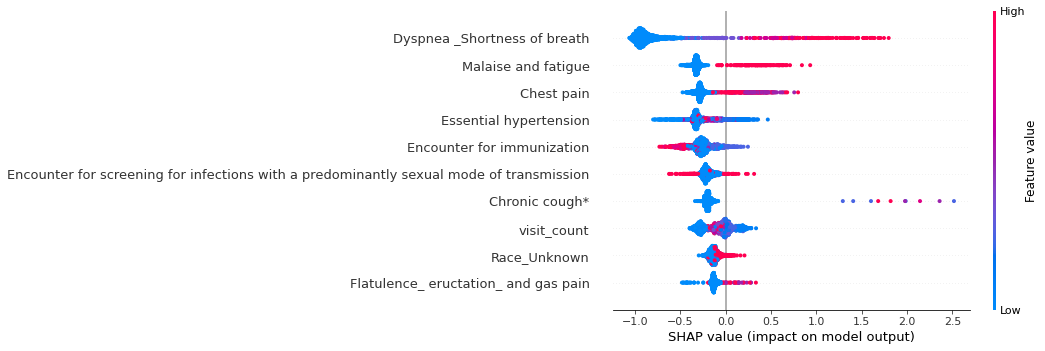

In [45]:
# Convert the numpy arrays back to DataFrames to preserve feature names
X_test = pd.DataFrame(X_test, columns=feature_names)

# Import SHAP
import shap

# Create a Tree explainer for the best LightGBM model
explainer = shap.TreeExplainer(best_lgb_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Plot summary_plot for the positive class (usually class index 1)
shap.summary_plot(shap_values[1], X_test, max_display=10)

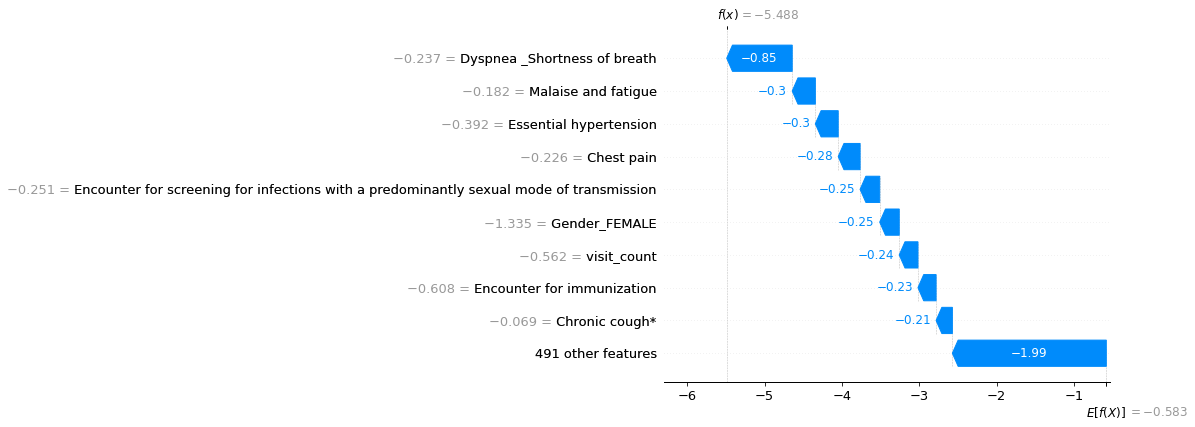

In [46]:
import shap

# Create a SHAP Tree explainer for the best LightGBM model
explainer = shap.TreeExplainer(best_lgb_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Create a SHAP Explanation object for the first instance in the test set
explanation = shap.Explanation(values=shap_values[1][0], 
                               base_values=explainer.expected_value[1], 
                               data=X_test.iloc[0], 
                               feature_names=X_test.columns.tolist())

# Visualize the first prediction's explanation using a waterfall plot
shap.plots.waterfall(explanation)

In [47]:
person_ids_to_select = [1991813, 3035829, 1990878, 1814700, 2270188, 2143561, 1586566, 2054655, 1305342, 1251904]
# Filter the DataFrame
data_selected = mgd_df2[mgd_df2['PERSON_ID'].isin(person_ids_to_select)]
merged_df2 = data_selected.drop('PERSON_ID', axis=1)

In [48]:
merged_df2 = merged_df2.drop(['Sars-CoV-2*','Post COVID-19 condition*'], axis=1)

In [49]:
import pandas as pd

def clean_column_name(column_name):
    # Replace unsupported characters with an underscore
    for ch in [':', ',', '{', '}', '\n', '[', ']', '"', '\\']:
        column_name = column_name.replace(ch, '_')

    # Remove leading and trailing underscores
    column_name = column_name.strip('_')

    return column_name

def make_unique(column_names):
    seen = set()
    unique_column_names = []
    for col in column_names:
        col_cleaned = clean_column_name(col)
        while col_cleaned in seen:
            col_cleaned += "_1"
        unique_column_names.append(col_cleaned)
        seen.add(col_cleaned)
    return unique_column_names

# Replace 'your_dataframe' with the actual variable name of your dataframe
merged_df2.columns = make_unique(merged_df2.columns)

In [50]:
# Apply feature importance (select the same top features used during training)
filtered_unlabeled_data = merged_df2[top_features]

#filtered_unlabeled_data = filtered_df.drop('Post covid-19 condition_ unspecified',axis=1)

In [51]:
# Apply the model to the unseen data
unseen_data_predictions1 = best_lgb_model.predict(filtered_unlabeled_data)

# If you want predicted probabilities instead of class labels, use the following:
unseen_data_probabilities1 = best_lgb_model.predict_proba(filtered_unlabeled_data)[:, 1]

print(unseen_data_predictions1)
print(unseen_data_probabilities1)

[1 1 1 1 1 1 1 1 1 1]
[0.99505053 0.99524544 0.9937439  0.99551588 0.98460373 0.99345359
 0.96039712 0.99206781 0.90466226 0.97557972]


In [52]:
# Apply the model to the unseen data
unseen_data_predictions = stacking_model.predict(filtered_unlabeled_data)

# If you want predicted probabilities instead of class labels, use the following:
unseen_data_probabilities = stacking_model.predict_proba(filtered_unlabeled_data)[:, 1]

print(unseen_data_predictions)
print(unseen_data_probabilities)

[1 1 1 1 1 1 1 1 1 1]
[0.99963585 0.99963585 0.99963585 0.99963469 0.99963585 0.99963585
 0.99963585 0.99973641 0.99963585 0.99963585]


X has feature names, but SVC was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but BaggingClassifier was fitted without feature names
X has feature names, but SVC was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but BaggingClassifier was fitted without feature names


In [53]:
# Create a new DataFrame with the original data and the predicted labels
unlabeled_data_with_predictions = pd.DataFrame(data_selected['PERSON_ID'])
unlabeled_data_with_predictions['predicted_label'] = unseen_data_predictions

# If you want to add predicted probabilities instead of class labels, use the following:
unlabeled_data_with_predictions['predicted_probability'] = unseen_data_probabilities

# Now you can view the results by printing the DataFrame
unlabeled_data_with_predictions.head(10)

,PERSON_ID,predicted_label,predicted_probability
2589,1586566,1,0.999636
6154,3035829,1,0.999636
6177,1814700,1,0.999636
8014,1305342,1,0.999635
8475,1251904,1,0.999636
8711,2054655,1,0.999636
9350,2270188,1,0.999636
9387,2143561,1,0.999736
9951,1990878,1,0.999636
10200,1991813,1,0.999636


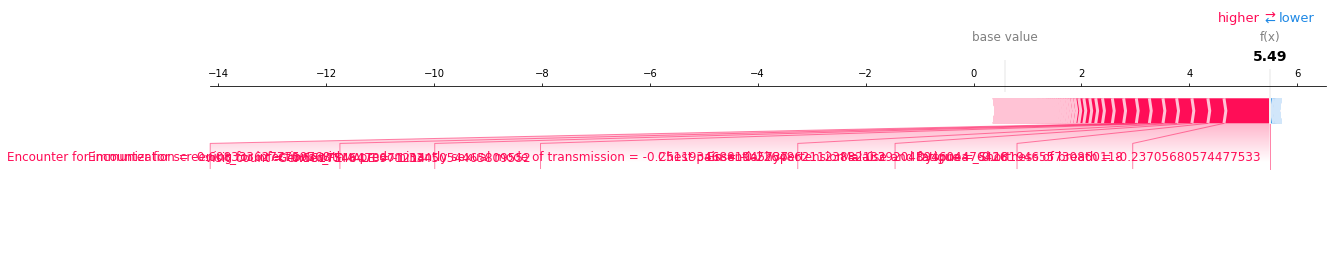

In [54]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)